## Objective: 

**Predicting BTCUSDT Price Trend Using MACD**

**Purpose**: 

Instead of trying to guess the exact price of BTCUSDT in the next hour, we now want to know its general movement: Is it going up or down? And how strongly? We'll use MACD idicator to identif the trend. But often, by the time MACD tells us something, it's too late to act. So, our goal is to make a model that reads MACD early, letting us know ahead of time.

**What Went Wrong?**: 

In our previous experiment, we tried to guess the exact price of BTCUSDT after one hour. But our model was just making random guesses, especially for prices going up (+1) or down (-1). So, it didn't work well.

**Data source**: 

- Binance
- BTCUSDT hourly prices in JSON.

**Prediction Logic**:
- **+2 (Strong Upward Trend)**: Conditions – MACD value is positive and exhibits an increase from its previous value.
- **+1 (Weak Upward Trend)**: Conditions – MACD value remains positive, but there's a decrease relative to its prior value.
- **-2 (Strong Downward Trend)**: Conditions – MACD value is negative and further decreases from its preceding value.
- **-1 (Weak Downward Trend)**: Conditions – MACD is negative but shows an increase when juxtaposed with its preceding value.


### Target and features

In [1]:
import numpy as np
import pandas as pd
import talib

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # change datetime to index
    df.set_index('datetime', inplace=True)
    
    df = remove_outlier(df)
    return df

Explore MACD

In [16]:
df = read_hist_data(name = 'BTC', timeframe = '1h')

# use OHLC to calculate MACD to reduce noise
df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

# MACD standard
df['macd'], df['macd_signal'], df['macd_hist'] = talib.MACD(df['ohlc'], fastperiod=12, slowperiod=26, signalperiod=9)

# Refer Histogram level to ohlc
df['macd_hist_ref'] = df['macd_hist'] / df['ohlc'] * 100

df.describe()


,open,high,low,close,volume,ohlc,macd,macd_signal,macd_hist,macd_hist_ref
count,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000,22882.000000,22882.000000,22882.000000,22882.000000
mean,35117.336473,35297.705123,34928.163154,35117.620848,4477.749672,35115.206400,-0.994906,-0.986205,-0.008701,-0.000020
std,13125.131469,13210.580569,13033.198250,13125.379765,4697.700455,13122.679589,319.613944,300.911657,96.355760,0.247338
min,15648.230000,15769.990000,15476.000000,15649.520000,5.887034,15690.757500,-2381.545833,-2078.161228,-708.712928,-1.495016
25%,23415.510000,23483.855000,23341.975000,23414.470000,1398.628235,23412.668750,-118.995339,-116.996370,-38.194848,-0.114290
50%,32099.970000,32345.000000,31800.000000,32099.980000,2658.617538,32079.825000,-0.341699,-1.304715,-0.434578,-0.001665
75%,45197.645000,45485.530000,44869.145000,45197.975000,5828.032940,45213.873750,122.724489,119.800609,36.087915,0.111434
max,68635.120000,69000.000000,68451.190000,68633.690000,28721.893750,68596.272500,1869.445320,1731.084977,616.509597,1.447991


Lets test same set of features from previous experiment, but this time we will use MACD as target.

In [2]:

# to predict if the price will go up or down in the next period
def get_target_next_macd(df, target_shift = 1):

    target_threshold = 0.1

    # oclh
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    # MACD standard
    macd, macdsignal, macdhist  = talib.MACD(df['ohlc'], fastperiod=12, slowperiod=26, signalperiod=9)

    # Refer Histogram level to ohlc
    df['macdhist'] = macdhist / df['ohlc'] * 100

    conditions = [
        (df['macdhist'].isnull()),
        (df['macdhist'] > target_threshold) & (df['macdhist'] > df['macdhist'].shift(1)),
        (df['macdhist'] > target_threshold) & (df['macdhist'] <= df['macdhist'].shift(1)),
        (df['macdhist'] < target_threshold * -1) & (df['macdhist'] >= df['macdhist'].shift(1)),
        (df['macdhist'] < target_threshold * -1) & (df['macdhist'] < df['macdhist'].shift(1))
    ]
    values = [np.nan, 2, 1, -1, -2]
    df['target'] = np.select(conditions, values, default=0,)

    # shift target to future
    df['target'] = df['target'].shift(target_shift * -1)

    # drop unused columns
    drop_columns = ['ohlc', 'macdhist']
    df.drop(drop_columns, axis=1, inplace=True)
    
    return df

def get_features_v1(df):
    df = df.copy()

    # List of periods
    periods = [3, 5, 10, 20, 40, 80]
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df['volume'] = np.log(df['volume'])

    # ohlc
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
        
        
            # Generate indicators

            # % of change
            df.loc[:, f'{input}_pct_{period}'] = df[input].pct_change(periods=period)

            # EMAs
            df.loc[:, f'{input}_ema_{period}'] = talib.EMA(df[input].values, timeperiod=period)

            # RSI
            df.loc[:, f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df.loc[:, f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            df.loc[:, f'{input}_sd_{period}'] = talib.STDDEV(df[input].values, timeperiod=period)

            # ROC
            df.loc[:, f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df.loc[:, f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)


        df = df.copy()
        
        # Multiple inputs indicators
        # ATR
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df.loc[:, f'price_atr_{period}'] = atr

        # Price interaction Features:
        df.loc[:, f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df.loc[:, f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df.loc[:, f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df.loc[:, f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df.loc[:, f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)


    df = df.copy()
    
    return df

df = read_hist_data()
df = get_target_next_macd(df)
df = get_features_v1(df)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    10358
-2.0     3265
 2.0     3130
 1.0     2989
-1.0     2934
Name: count, dtype: int64
Shape (22676, 253)


,open,high,low,close,volume,target,ohlc,open_pct_3,open_ema_3,open_rsi_3,...,volume_trix_80,volume_sd_80,volume_roc_80,volume_var_80,price_atr_80,price_interact_80,pv_interact_80,price_adx_80,mfi_80,price_dx_80
count,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,...,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000,22676.000000
mean,35119.474608,35297.924274,34932.766292,35119.358703,7.956264,-0.009481,35117.380969,0.000032,35119.995834,50.141034,...,-0.000756,0.507078,0.527117,0.271079,369.674408,-1.122671,-0.000306,13.488741,50.222947,13.596653
std,13187.442326,13273.257147,13095.169048,13187.740972,0.947552,1.178659,13185.039482,0.012754,13185.263635,23.979804,...,0.029637,0.118117,11.124851,0.131423,240.670289,35.640334,0.007603,6.115836,5.729443,10.640867
min,15648.230000,15769.990000,15476.000000,15649.520000,1.772752,-2.000000,15690.757500,-0.113669,15715.807134,0.164893,...,-0.142974,0.271230,-77.445199,0.073566,37.364503,-317.718029,-0.097869,3.709515,31.638686,0.000563
25%,23358.705000,23439.325000,23269.340000,23355.080000,7.235698,-1.000000,23360.765625,-0.004726,23361.218590,31.570859,...,-0.018797,0.415276,-6.567653,0.172454,162.803224,-9.242100,-0.001890,9.130853,46.185918,5.343820
50%,31883.545000,32163.280000,31671.145000,31881.755000,7.877857,0.000000,31895.716250,0.000018,31921.477297,50.399341,...,-0.001035,0.483974,-0.101862,0.234231,315.535000,-0.103217,-0.000005,11.921938,50.032979,11.197398
75%,45445.780000,45776.395000,45150.000000,45445.790000,8.670391,1.000000,45436.323125,0.004721,45482.157850,68.740332,...,0.016359,0.586128,6.872177,0.343546,538.664388,10.468266,0.001707,16.205516,54.030398,19.276040
max,68635.120000,69000.000000,68451.190000,68633.690000,10.265415,2.000000,68596.272500,0.147444,68469.229095,99.751964,...,0.124158,0.990415,330.676978,0.980922,1290.661348,227.240465,0.309765,40.244988,69.827068,74.174616


### Experiment 1: Predict trend further that 1 period into the future

In [107]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

random_state = 55

# create dataframe with target of x periods in the future
for i in range(1, 6):
    print(f"Predict MACD level in next {i} period(s)")

    df = read_hist_data()
    df = get_target_next_macd(df, target_shift=i)
    df = get_features_v1(df)
    df = df.dropna()

    # print(df.head(5))
    # print(df.tail(5))

    # Pre data for classification
    drop_columns = ['target']
    X = df.drop(columns=drop_columns)
    y = df['target']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

    model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print("=================\n")

Predict MACD level in next 1 period(s)
Confusion Matrix
[[ 396   57  168    0    0]
 [  65  436  117    0    0]
 [  24   17 4303   13   32]
 [   0    0  124  379   72]
 [   2    0  144   42  412]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.81      0.64      0.71       621
        -1.0       0.85      0.71      0.77       618
         0.0       0.89      0.98      0.93      4389
         1.0       0.87      0.66      0.75       575
         2.0       0.80      0.69      0.74       600

    accuracy                           0.87      6803
   macro avg       0.85      0.73      0.78      6803
weighted avg       0.87      0.87      0.86      6803


Predict MACD level in next 2 period(s)
Confusion Matrix
[[ 258   70  289    2    2]
 [ 105  393  120    0    0]
 [  41   26 4155   18  149]
 [   0    0  109  348  118]
 [   4    1  231   65  299]]
Classification Report
              precision    recall  f1-score   support

        -2.0     

Performance of the model drop significantly when we try to predict further than 1 period into the future.
- However f1 and accuracy of 2 periods still acceptable with 0.50-0.89 and 0.80 respectively.
- We will use 2 periods into the future for our next experiment since predicting 1 ahead might not have enough room to take action.

----

### Experiment 2: Identify the most / least important features for Classification

Get dataframe of feature and target t+2

In [109]:
df = read_hist_data()
df = get_target_next_macd(df, target_shift=2)
df = get_features_v1(df)
df = df.dropna()

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)
y = df['target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

In [110]:
model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

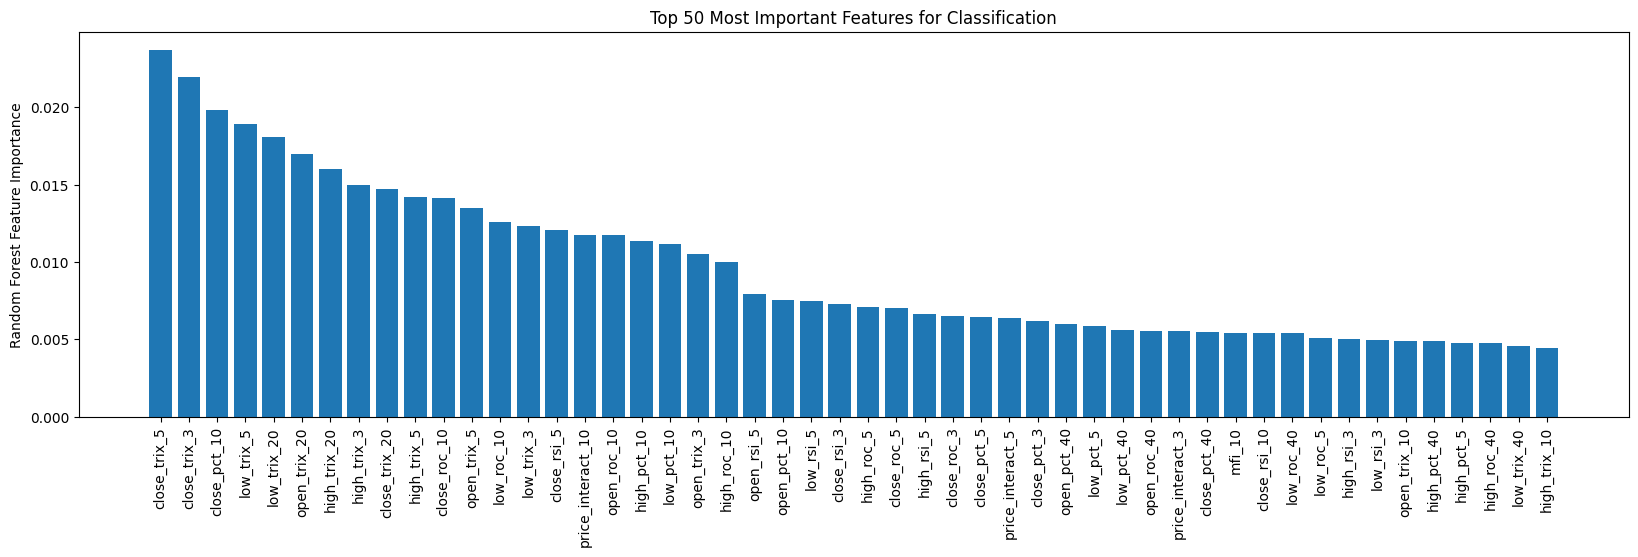

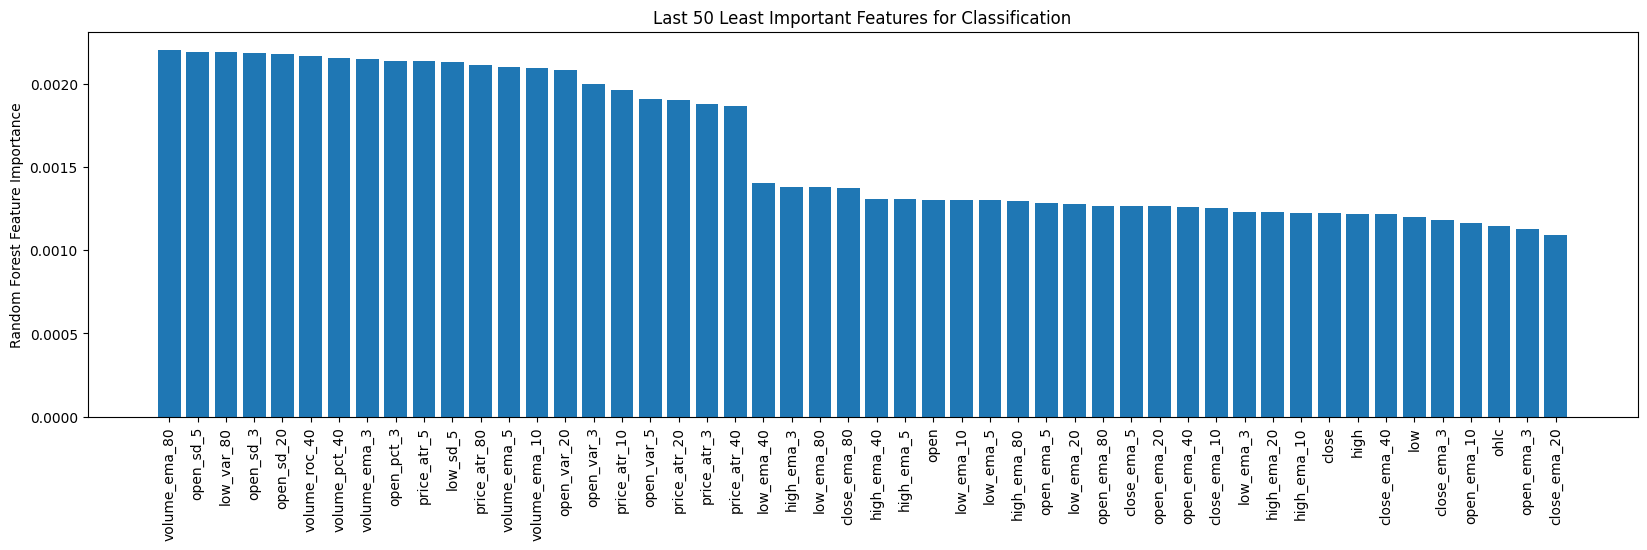

In [111]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top features
top_indices = sorted_idx[:50]
top_importances = importances[top_indices]
top_features_classification = X.columns[top_indices]

plt.figure(figsize=(20, 5))
plt.bar(top_features_classification, top_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

# Get last 50 features
last_indices = sorted_idx[-50:]
last_importances = importances[last_indices]
last_features_classification = X.columns[last_indices]

plt.figure(figsize=(20, 5))
plt.bar(last_features_classification, last_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()


In [ ]:
# print("top_50_features_classification =", top_features_classification)
# print("last_50_features_classification =",last_features_classification)

Interpretation:

- The top features emphasize the significance of the trend and momentum in determining the MACD level, with 'trix' and 'roc' being particularly notable.
- Shorter indicator period lengths (e.g. 3, 5, 10) appear to be more important than longer ones (e.g. 80).
- Conversely, simple price levels (like 'open', 'close', 'high', 'low') and some revolve around 'volume', 'sd' (standard deviation), 'var' (variance), 'ema' (exponential moving average), and 'atr' (average true range) appear to have less impact on predicting the MACD trend.

In [3]:
def get_features_v2(df):
    df = df.copy()

    # List of periods
    periods = [3, 5, 10, 15, 20, 25]
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df['volume'] = np.log(df['volume'])

    # ohlc
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
        
        
            # Generate indicators

            # % of change
            df.loc[:, f'{input}_pct_{period}'] = df[input].pct_change(periods=period)

            # EMAs
            # df.loc[:, f'{input}_ema_{period}'] = talib.EMA(df[input].values, timeperiod=period)

            # RSI
            df.loc[:, f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df.loc[:, f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            # df.loc[:, f'{input}_sd_{period}'] = talib.STDDEV(df[input].values, timeperiod=period)

            # ROC
            df.loc[:, f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            # df.loc[:, f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)


        df = df.copy()
        
        # Multiple inputs indicators
        # ATR
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df.loc[:, f'price_atr_{period}'] = atr

        # Price interaction Features:
        df.loc[:, f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df.loc[:, f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df.loc[:, f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df.loc[:, f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df.loc[:, f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    # Drop unused columns
    drop_columns = ['ohlc', 'open', 'high', 'low', 'close', 'volume']
    df.drop(drop_columns, axis=1, inplace=True)

    df = df.copy()
    
    return df

df = read_hist_data()
df = get_target_next_macd(df)
df = get_features_v2(df)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    10403
-2.0     3300
 2.0     3160
 1.0     3012
-1.0     2966
Name: count, dtype: int64
Shape (22841, 157)


,target,open_pct_3,open_rsi_3,open_trix_3,open_roc_3,high_pct_3,high_rsi_3,high_trix_3,high_roc_3,low_pct_3,...,volume_pct_25,volume_rsi_25,volume_trix_25,volume_roc_25,price_atr_25,price_interact_25,pv_interact_25,price_adx_25,mfi_25,price_dx_25
count,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,...,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000,22841.000000
mean,-0.010245,0.000051,50.177588,-0.000707,0.005082,0.000044,48.183076,-0.000753,0.004378,0.000063,...,0.004032,49.936664,-0.000667,0.403212,371.494819,-0.440448,-0.000226,21.835624,50.259745,21.835749
std,1.180245,0.012869,23.982011,0.268624,1.286851,0.012377,25.870996,0.263060,1.237729,0.013622,...,0.094315,2.934495,0.114960,9.431475,255.666197,24.330804,0.004059,9.786979,10.179962,16.323357
min,-2.000000,-0.113669,0.164893,-2.289916,-11.366926,-0.104237,0.047130,-2.067749,-10.423686,-0.152855,...,-0.763040,27.157503,-0.415390,-76.304045,26.149550,-276.323229,-0.050204,4.967913,15.665619,0.002850
25%,-1.000000,-0.004743,31.590305,-0.095403,-0.474265,-0.004854,27.154718,-0.100728,-0.485414,-0.004781,...,-0.053896,47.893904,-0.067286,-5.389590,162.097393,-4.650569,-0.000797,14.636944,43.529823,8.602161
50%,0.000000,0.000031,50.438791,0.001389,0.003083,-0.000398,47.454389,-0.007259,-0.039787,0.000464,...,-0.002002,49.614401,0.001174,-0.200151,317.610398,-0.005569,-0.000009,19.671007,50.815568,18.632543
75%,1.000000,0.004780,68.782639,0.097489,0.478003,0.004526,68.496370,0.095562,0.452584,0.005258,...,0.053903,51.731347,0.066828,5.390291,536.724143,4.813768,0.000644,27.070822,56.588249,31.830680
max,2.000000,0.147444,99.751964,2.167046,14.744365,0.147800,99.924076,2.402430,14.780014,0.143330,...,3.386263,64.403163,0.429206,338.626256,1815.752131,248.133257,0.197670,70.290866,92.594971,93.441613


**Compare performance by predicting target in further periods**

In [141]:
random_state = 55

# create dataframe with target of x periods in the future
for i in range(1, 4):
    print(f"Predict MACD level in next {i} period(s)")

    df = read_hist_data()
    df = get_target_next_macd(df, target_shift=i)
    df = get_features_v2(df)
    df = df.dropna()

    # print(df.head(5))
    # print(df.tail(5))

    # Pre data for classification
    drop_columns = ['target']
    X = df.drop(columns=drop_columns)
    y = df['target']

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

    model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print("=================\n")

Predict MACD level in next 1 period(s)
Confusion Matrix
[[ 427   62  143    1    0]
 [  66  477   85    0    0]
 [  21   16 4319   14   26]
 [   0    0   81  438   67]
 [   1    0  111   58  440]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.83      0.67      0.74       633
        -1.0       0.86      0.76      0.81       628
         0.0       0.91      0.98      0.95      4396
         1.0       0.86      0.75      0.80       586
         2.0       0.83      0.72      0.77       610

    accuracy                           0.89      6853
   macro avg       0.86      0.78      0.81      6853
weighted avg       0.89      0.89      0.89      6853


Predict MACD level in next 2 period(s)
Confusion Matrix
[[ 286   76  268    3    0]
 [ 118  419   91    0    0]
 [  51   27 4233   19   65]
 [   0    0   88  386  112]
 [   5    2  221   83  299]]
Classification Report
              precision    recall  f1-score   support

        -2.0     

**Observation:**
- We reduce number of columns from 253 to 157 and get better performance.
- Perfromance at T+1
    - F1 from 0.50-0.89 to 0.74-0.95
    - Accuracy from 0.80 to 0.89
- Perfromance at T+1
    - F1 from 0.50-0.89 to 0.52-0.91
    - Accuracy from 0.80 to 0.82
- We will use this set of features with Target T+2 for our next experiment.

----

### Experiment 3: Test Pre-process the data with alternative models

Dataframe of feature V2 and target t+2

In [144]:
df = read_hist_data()
df = get_target_next_macd(df, target_shift=2)
df = get_features_v2(df)
df = df.dropna()

In [145]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

drop_columns = ['target']
X = df.drop(columns=drop_columns)
y = df['target']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

scaler_std = StandardScaler()

# Fit the scaler using the training data
X_train_scale_std = scaler_std.fit_transform(X_train)
X_test_scale_std = scaler_std.transform(X_test)

scaler_mm = MinMaxScaler()

# Fit the scaler using the training data
X_train_scale_mm = scaler_mm.fit_transform(X_train)
X_test_scale_mm = scaler_mm.transform(X_test)

sm = SMOTE(random_state=random_state)

# Z-Score Normalization
X_train_std_sm, y_train_std_sm = sm.fit_resample(X_train_scale_std, y_train)

# Min-Max Scaling
X_train_mm_sm, y_train_mm_sm = sm.fit_resample(X_train_scale_mm, y_train)

In [146]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import time

# import warnings
# from sklearn.exceptions import ConvergenceWarning

# # Ignore ConvergenceWarning
# warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define classifiers
classifiers = {
    "Random Forest (Baseline)": RandomForestClassifier(random_state=random_state, n_jobs=-1),
    "Logistic Regression": LogisticRegression(random_state=random_state, solver='saga', max_iter=10000, n_jobs=-1),
    "SVM rbf": SVC(kernel='rbf', random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "K-Nearest Neighbors": KNeighborsClassifier(n_jobs=-1),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "AdaBoost": AdaBoostClassifier(random_state=random_state),
    'LightGBM': lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1),
}

# Datasets
datasets = {
    "no_scale_no_SMOTE": (X_train, y_train, X_test, y_test),
    "StandardScaler_no_SMOTE": (X_train_scale_std, y_train, X_test_scale_std, y_test),
    "MinMaxScaler_no_SMOTE": (X_train_scale_mm, y_train, X_test_scale_mm, y_test),
    "StandardScaler_SMOTE": (X_train_std_sm, y_train_std_sm, X_test_scale_std, y_test),
    "MinMaxScaler_SMOTE": (X_train_mm_sm, y_train_mm_sm, X_test_scale_mm, y_test)
}

results = {}

for dataset_name, (iX_train, iy_train, iX_test, iy_test) in datasets.items():
    for classifier_name, classifier in classifiers.items():
        # Calculate execute start time
        start = time.time()
        
        print(f"Training {classifier_name} on {dataset_name}...", end=" ")

        try:
            # Train the model
            model = classifier
            model.fit(iX_train, iy_train)
            y_pred = model.predict(iX_test)
            
            # Compute metrics
            accuracy = accuracy_score(iy_test, y_pred)
            f1 = f1_score(iy_test, y_pred, average='weighted')
            precision = precision_score(iy_test, y_pred, average='weighted', zero_division=0)
            recall = recall_score(iy_test, y_pred, average='weighted')
        except Exception as e:
            # print(f"Error: {e}")
            accuracy = 0
            f1 = 0
            precision = 0
            recall = 0
        
        # Save results
        results[(dataset_name, classifier_name)] = {
            'Accuracy': accuracy,
            'F1-Score': f1,
            'Precision': precision,
            'Recall': recall
        }

        # Calculate execute duration
        duration = time.time() - start
        print(f"- Duration: {duration/60:.2f} minutes")

print("\nDone!\n")
# Print results
for (dataset_name, classifier_name), metrics in results.items():
    print(f"Results for {classifier_name} with {dataset_name}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    print("=====================================")



Training Random Forest (Baseline) on no_scale_no_SMOTE... - Duration: 0.02 minutes
Training Logistic Regression on no_scale_no_SMOTE... - Duration: 2.20 minutes
Training SVM rbf on no_scale_no_SMOTE... - Duration: 0.27 minutes
Training Decision Tree on no_scale_no_SMOTE... - Duration: 0.06 minutes
Training K-Nearest Neighbors on no_scale_no_SMOTE... - Duration: 0.00 minutes
Training Naive Bayes on no_scale_no_SMOTE... - Duration: 0.00 minutes
Training Gradient Boosting on no_scale_no_SMOTE... - Duration: 5.55 minutes
Training AdaBoost on no_scale_no_SMOTE... - Duration: 0.22 minutes
Training LightGBM on no_scale_no_SMOTE... - Duration: 0.22 minutes
Training Random Forest (Baseline) on StandardScaler_no_SMOTE... - Duration: 0.02 minutes
Training Logistic Regression on StandardScaler_no_SMOTE... - Duration: 1.53 minutes
Training SVM rbf on StandardScaler_no_SMOTE... - Duration: 0.16 minutes
Training Decision Tree on StandardScaler_no_SMOTE... - Duration: 0.06 minutes
Training K-Nearest N

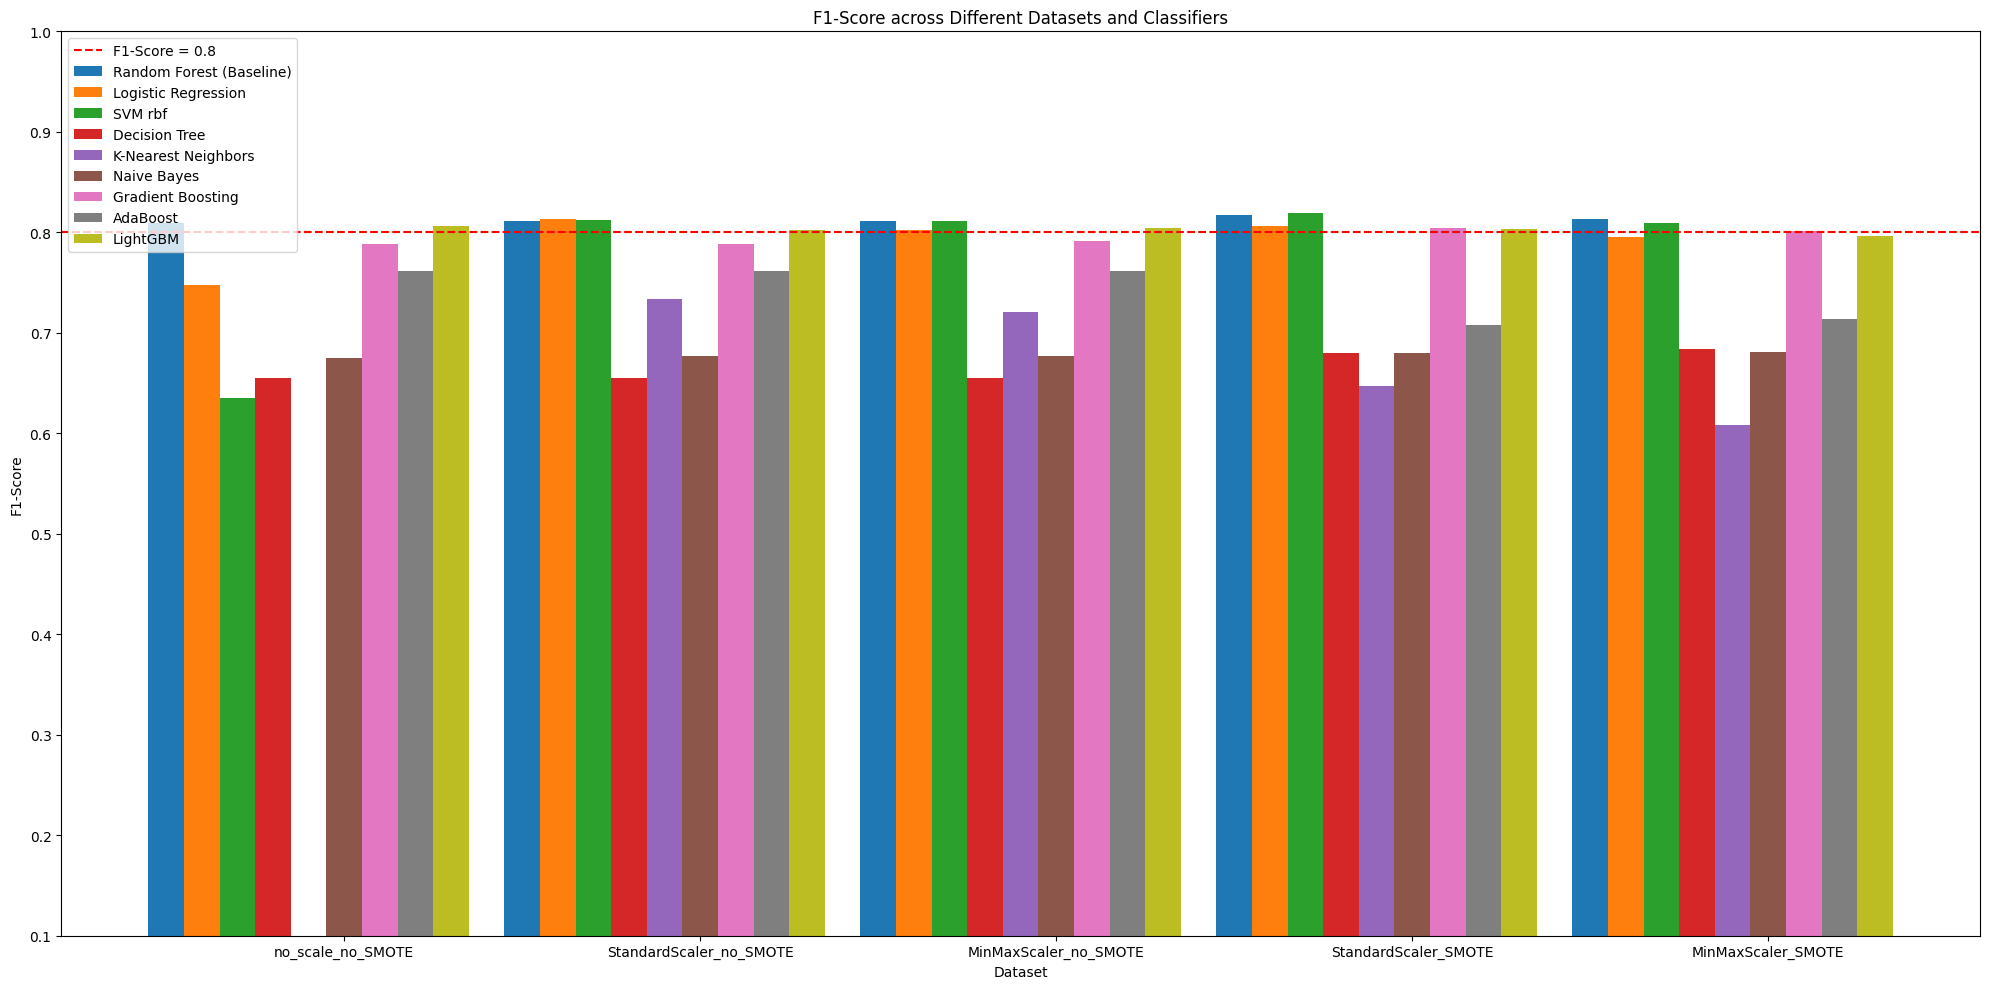

In [154]:
import matplotlib.pyplot as plt

# Extract F1-Scores from the results
f1_scores = {}
for (dataset_name, classifier_name), metrics in results.items():
    if classifier_name not in f1_scores:
        f1_scores[classifier_name] = {}
    f1_scores[classifier_name][dataset_name] = metrics['F1-Score']

# Plot F1-Scores
plt.figure(figsize=(20,10))

# List of classifier names
classifier_names = list(f1_scores.keys())

# Generate bar positions
bar_positions = list(range(len(datasets)))

# For each classifier, plot a bar for each dataset
for idx, (classifier_name, scores) in enumerate(f1_scores.items()):
    plt.bar([pos + 0.1 * idx for pos in bar_positions], scores.values(), width=0.1, label=classifier_name)

# increase x height
plt.ylim(0.1, 1)

plt.xlabel('Dataset')
plt.ylabel('F1-Score')
plt.title('F1-Score across Different Datasets and Classifiers')
plt.xticks([pos + 0.5 for pos in bar_positions], list(datasets.keys()))
plt.axhline(y=0.8, color='r', linestyle='--', label='F1-Score = 0.8')

plt.legend()
plt.tight_layout()
plt.show()


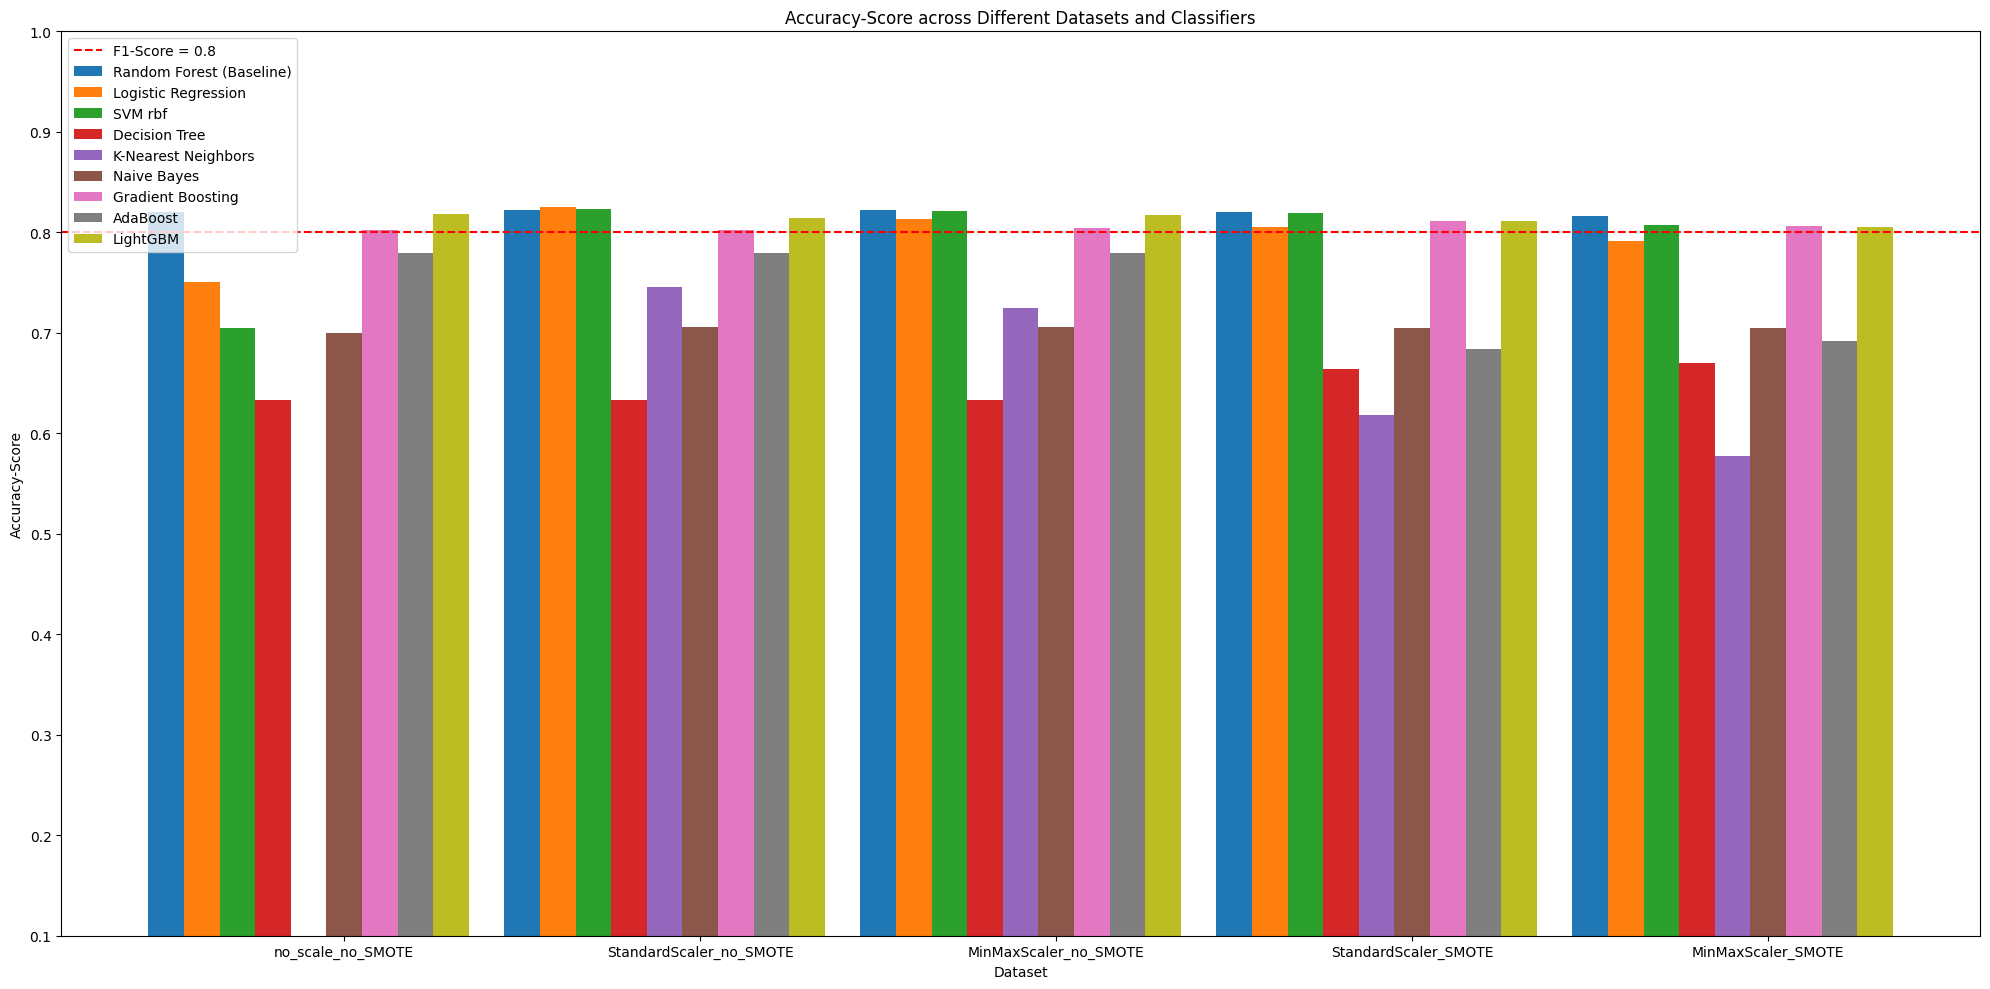

In [153]:
import matplotlib.pyplot as plt

# Extract accuracy-Scores from the results
accuracy_scores = {}
for (dataset_name, classifier_name), metrics in results.items():
    if classifier_name not in accuracy_scores:
        accuracy_scores[classifier_name] = {}
    accuracy_scores[classifier_name][dataset_name] = metrics['Accuracy']

# Plot Accuracy-Scores
plt.figure(figsize=(20,10))

# List of classifier names
classifier_names = list(accuracy_scores.keys())

# Generate bar positions
bar_positions = list(range(len(datasets)))

# For each classifier, plot a bar for each dataset
for idx, (classifier_name, scores) in enumerate(accuracy_scores.items()):
    plt.bar([pos + 0.1 * idx for pos in bar_positions], scores.values(), width=0.1, label=classifier_name)

# increase x height
plt.ylim(0.1, 1)

plt.xlabel('Dataset')
plt.ylabel('Accuracy-Score')
plt.title('Accuracy-Score across Different Datasets and Classifiers')
plt.xticks([pos + 0.5 for pos in bar_positions], list(datasets.keys()))
# dash horizontal line at y = 0.8
plt.axhline(y=0.8, color='r', linestyle='--', label='F1-Score = 0.8')
plt.legend()
plt.tight_layout()
plt.show()


**Set threshold = 0.8**, These are the models that meet the criteria of both F1 and Accuracy > 0.8
- It appears that `Random Forest`, `SVM (with RBF kernel)`, and `LightGBM` are the top-performing models across different data transformations. 
- For pre-processing, the `StandardScaler_no_SMOTE` and `MinMaxScaler_no_SMOTE` data transformations seem to yield the best results for these models.


For next experiment
- We will test these models in detail with `StandardScaler_no_SMOTE` dataset
    - Random Forest
    - Logistic Regression
    - SVM (with RBF kernel)
    - Gradient Boosting
    - LightGBM

----

### Experiment 4: Test Base Models for Ensemble Method

#### Test Base models performance:

In [155]:
# Feature and target t+2

df = read_hist_data()
df = get_target_next_macd(df, target_shift=2)
df = get_features_v2(df)
df = df.dropna()

Pre-process the data with `StandardScaler` without `SMOTE`

In [156]:
# Rewrite pre-processing steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

In [158]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import time

##### Bagging with RandomForest

In [180]:
# Randon Forest Baseline model
time_start = time.time()
model_rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)

# Fit model and predict
model_rf.fit(X_train_pre, y_train)
y_pred = model_rf.predict(X_test_pre)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 292   77  261    3    0]
 [ 120  419   89    0    0]
 [  50   28 4230   19   68]
 [   0    0   89  388  109]
 [   4    2  219   82  303]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.63      0.46      0.53       633
        -1.0       0.80      0.67      0.73       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.79      0.66      0.72       586
         2.0       0.63      0.50      0.56       610

    accuracy                           0.82      6852
   macro avg       0.74      0.65      0.69      6852
weighted avg       0.81      0.82      0.81      6852

Duration: 0.02 minutes


In [175]:
# Bagging Random Forest model
time_start = time.time()
model_bagging_rf = BaggingClassifier(estimator=model_rf, 
                    n_estimators=100,
                    random_state=random_state, n_jobs=-1)

model_bagging_rf.fit(X_train_pre, y_train)
y_pred = model_bagging_rf.predict(X_test_pre)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 271   83  275    3    1]
 [ 107  420  101    0    0]
 [  37   26 4243   24   65]
 [   0    0   92  381  113]
 [   4    1  217   81  307]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.65      0.43      0.52       633
        -1.0       0.79      0.67      0.73       628
         0.0       0.86      0.97      0.91      4395
         1.0       0.78      0.65      0.71       586
         2.0       0.63      0.50      0.56       610

    accuracy                           0.82      6852
   macro avg       0.74      0.64      0.68      6852
weighted avg       0.81      0.82      0.81      6852

Duration: 1.58 minutes


##### Logistic Regression

In [181]:
time_start = time.time()
# model_lr = LogisticRegression(random_state=random_state, solver='saga', max_iter=10000, n_jobs=-1)
model_lr = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)

model_lr.fit(X_train_pre, y_train)
y_pred = model_lr.predict(X_test_pre)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Duration: {duration/60:.2f} minutes")


Confusion Matrix
[[ 283  113  236    1    0]
 [  90  451   87    0    0]
 [  48   36 4225   28   58]
 [   0    0   66  423   97]
 [   2    2  213  115  278]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.67      0.45      0.54       633
        -1.0       0.75      0.72      0.73       628
         0.0       0.88      0.96      0.92      4395
         1.0       0.75      0.72      0.73       586
         2.0       0.64      0.46      0.53       610

    accuracy                           0.83      6852
   macro avg       0.74      0.66      0.69      6852
weighted avg       0.81      0.83      0.81      6852

Duration: 0.08 minutes


##### SVM RBF

In [182]:
time_start = time.time()
model_svm = SVC(kernel='rbf', random_state=random_state, probability=True) # need probability for voting

model_svm.fit(X_train_pre, y_train)
y_pred = model_svm.predict(X_test_pre)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 281   97  251    3    1]
 [  99  450   79    0    0]
 [  49   30 4208   30   78]
 [   0    0   89  402   95]
 [   4    1  203  104  298]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.65      0.44      0.53       633
        -1.0       0.78      0.72      0.75       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.75      0.69      0.71       586
         2.0       0.63      0.49      0.55       610

    accuracy                           0.82      6852
   macro avg       0.74      0.66      0.69      6852
weighted avg       0.81      0.82      0.81      6852

Duration: 0.54 minutes


##### Gradient Boosting

In [179]:
time_start = time.time()
model_gb = GradientBoostingClassifier(random_state=random_state)

model_gb.fit(X_train_pre, y_train)
y_pred = model_gb.predict(X_test_pre)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 259   82  288    3    1]
 [  93  405  129    0    1]
 [  37   29 4189   23  117]
 [   0    0  117  384   85]
 [   5    2  248   96  259]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.66      0.41      0.50       633
        -1.0       0.78      0.64      0.71       628
         0.0       0.84      0.95      0.89      4395
         1.0       0.76      0.66      0.70       586
         2.0       0.56      0.42      0.48       610

    accuracy                           0.80      6852
   macro avg       0.72      0.62      0.66      6852
weighted avg       0.79      0.80      0.79      6852

Duration: 5.55 minutes


##### LightGBM

In [183]:
time_start = time.time()
model_lgb = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)

model_lgb.fit(X_train_pre, y_train)
y_pred = model_lgb.predict(X_test_pre)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 267  103  260    2    1]
 [  89  442   96    0    1]
 [  55   31 4198   29   82]
 [   0    0  106  396   84]
 [   1    1  228  104  276]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.65      0.42      0.51       633
        -1.0       0.77      0.70      0.73       628
         0.0       0.86      0.96      0.90      4395
         1.0       0.75      0.68      0.71       586
         2.0       0.62      0.45      0.52       610

    accuracy                           0.81      6852
   macro avg       0.73      0.64      0.68      6852
weighted avg       0.80      0.81      0.80      6852

Duration: 0.03 minutes


#### Ensemble Base models:

- Drop `Bagging RandomForest` and `Gradient Boosting` since it take too long to train without significant performance than other models
- Test between `Stacking` and `Voting` methods

##### Stacking Classifier with a Random Forest

In [185]:
# Define base models
time_start = time.time()
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        ('SVM rbf', model_svm),
        # ('Gradient Boosting', model_gb),
        ('LightGBM', model_lgb)
    ]

# Initialize the Stacking Classifier with a Random Forest as the final estimator
stacking_rf = StackingClassifier(
        estimators=base_estimators, 
        final_estimator=RandomForestClassifier(random_state=random_state, n_jobs=-1),
        stack_method='predict_proba'
    )

# Fit the model on the training data
stacking_rf.fit(X_train_pre, y_train)
y_pred = stacking_rf.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Calculate execute duration
duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Stacking Random Forest F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 350  128  150    3    2]
 [ 104  489   35    0    0]
 [ 210   79 3894   63  149]
 [   0    0   40  461   85]
 [   3    2  141  146  318]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.52      0.55      0.54       633
        -1.0       0.70      0.78      0.74       628
         0.0       0.91      0.89      0.90      4395
         1.0       0.68      0.79      0.73       586
         2.0       0.57      0.52      0.55       610

    accuracy                           0.80      6852
   macro avg       0.68      0.71      0.69      6852
weighted avg       0.81      0.80      0.81      6852

Stacking Random Forest F1-Score: 0.8058, Accuracy: 0.8044
Duration: 2.72 minutes


##### Stacking Classifier with a Logistic Regression

In [186]:
time_start = time.time()
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        ('SVM rbf', model_svm),
        # ('Gradient Boosting', model_gb),
        ('LightGBM', model_lgb)
    ]

stacking_lr = StackingClassifier(
        estimators=base_estimators, 
        final_estimator=LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1),
        stack_method='predict_proba'
    )

stacking_lr.fit(X_train_pre, y_train)
y_pred = stacking_lr.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Stacking Logistic Regression F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 328   89  214    1    1]
 [ 128  436   64    0    0]
 [  91   24 4173   21   86]
 [   0    0   71  409  106]
 [   4    1  191  102  312]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.60      0.52      0.55       633
        -1.0       0.79      0.69      0.74       628
         0.0       0.89      0.95      0.92      4395
         1.0       0.77      0.70      0.73       586
         2.0       0.62      0.51      0.56       610

    accuracy                           0.83      6852
   macro avg       0.73      0.67      0.70      6852
weighted avg       0.82      0.83      0.82      6852

Stacking Logistic Regression F1-Score: 0.8191, Accuracy: 0.8257
Duration: 2.75 minutes


##### Voting Classifier - Soft

In [187]:
time_start = time.time()
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        ('SVM rbf', model_svm),
        # ('Gradient Boosting', model_gb),
        ('LightGBM', model_lgb)
    ]

# Initialize the Voting soft Classifier
voting_soft = VotingClassifier(estimators=base_estimators, voting='soft', n_jobs=-1)

# Fit the model on the training data
voting_soft.fit(X_train_pre, y_train)
y_pred = voting_soft.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Voting soft F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 276   94  260    3    0]
 [  91  453   84    0    0]
 [  41   28 4233   24   69]
 [   0    0   86  407   93]
 [   3    1  212  102  292]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.67      0.44      0.53       633
        -1.0       0.79      0.72      0.75       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.76      0.69      0.73       586
         2.0       0.64      0.48      0.55       610

    accuracy                           0.83      6852
   macro avg       0.75      0.66      0.69      6852
weighted avg       0.81      0.83      0.81      6852

Voting soft F1-Score: 0.8145, Accuracy: 0.8262
Duration: 0.91 minutes


##### Voting Classifier - Hard

In [188]:
time_start = time.time()
base_estimators = [
        ('Random Forest', model_rf),
        # ('Bagging Random Forest', model_bagging_rf),
        ('Logistic Regression', model_lr),
        ('SVM rbf', model_svm),
        # ('Gradient Boosting', model_gb),
        ('LightGBM', model_lgb)
    ]

# Initialize the Voting soft Classifier
voting_hard = VotingClassifier(estimators=base_estimators, voting='hard', n_jobs=-1)

# Fit the model on the training data
voting_hard.fit(X_train_pre, y_train)
y_pred = voting_hard.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Voting Hard F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 297   88  245    3    0]
 [ 111  444   73    0    0]
 [  54   33 4236   21   51]
 [   0    0   99  403   84]
 [   4    2  235  104  265]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.64      0.47      0.54       633
        -1.0       0.78      0.71      0.74       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.76      0.69      0.72       586
         2.0       0.66      0.43      0.52       610

    accuracy                           0.82      6852
   macro avg       0.74      0.65      0.69      6852
weighted avg       0.81      0.82      0.81      6852

Voting Hard F1-Score: 0.8118, Accuracy: 0.8238
Duration: 0.82 minutes


**Observation:**

1. **Best Overall Performance:** The `Stacking Classifier with a Logistic Regression` has the highest F1-Score and Accuracy among the models. This would be a good choice without considering computational time.
2. **Best Trade-off between Performance and Speed:** The `Voting Classifier - Soft` offers almost the same performance as the Logistic Regression stacking but completes in about one-third of the time.
3. **Fastest:** The `Voting Classifier - Hard` is the fastest and still offers good performance metrics.
4. **Performance on Minor Classes:** All models seem to struggle more with classes `-2` and `+2`, indicating potential areas for improvement.

**Next step:** 
- We will choose `Voting Classifier - Soft` since it offers balance between speed and performance. 
- The precision and recall of class `-2` and `+2` are better than other models.

----

### Experiment 5: Hyper Parameter Tuning

Rewrite latest model

In [191]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
import time

In [192]:
# Feature and target t+2

df = read_hist_data()
df = get_target_next_macd(df, target_shift=2)
df = get_features_v2(df)
df = df.dropna()

# pre-processing steps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)


In [193]:
model_rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
model_lr = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)
model_svm = SVC(kernel='rbf', random_state=random_state, probability=True) 
model_lgb = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)

In [194]:
time_start = time.time()
base_estimators = [
        ('Random Forest', model_rf),
        ('Logistic Regression', model_lr),
        ('SVM rbf', model_svm),
        ('LightGBM', model_lgb)
    ]

# Initialize the Voting soft Classifier
model_voting = VotingClassifier(estimators=base_estimators, voting='soft', n_jobs=-1)

# Fit the model on the training data
model_voting.fit(X_train_pre, y_train)
y_pred = model_voting.predict(X_test_pre)

f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

duration = time.time() - time_start

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("Classification Report")
print(classification_report(y_test, y_pred))

print(f"Voting soft F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
print(f"Duration: {duration/60:.2f} minutes")

Confusion Matrix
[[ 276   94  260    3    0]
 [  91  453   84    0    0]
 [  41   28 4233   24   69]
 [   0    0   86  407   93]
 [   3    1  212  102  292]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.67      0.44      0.53       633
        -1.0       0.79      0.72      0.75       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.76      0.69      0.73       586
         2.0       0.64      0.48      0.55       610

    accuracy                           0.83      6852
   macro avg       0.75      0.66      0.69      6852
weighted avg       0.81      0.83      0.81      6852

Voting soft F1-Score: 0.8145, Accuracy: 0.8262
Duration: 0.78 minutes


let's perform hyperparameter tuning for each of the base classifiers separately. Once we obtain the best parameters for each classifier, we can combine them in the `VotingClassifier`.

##### Hyperparameter tuning for each classifier:

1. **Random Forest (RF)**
2. **Logistic Regression (LR)**
3. **Support Vector Machine (SVM)**
4. **LightGBM**

In [201]:
from sklearn.model_selection import GridSearchCV

# 1. Random Forest
param_grid_rf = {
    'n_estimators': [10, 50, 100, 200, 250],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rf = GridSearchCV(model_rf, param_grid_rf, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_rf.fit(X_train_pre, y_train)
best_params_rf = grid_search_rf.best_params_

print("Best Parameters for Random Forest:", best_params_rf)

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 250}


In [202]:
# predict with original model
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = RandomForestClassifier(**best_params_rf, random_state=random_state, n_jobs=-1)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -2.0       0.63      0.46      0.53       633
        -1.0       0.80      0.67      0.73       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.79      0.66      0.72       586
         2.0       0.63      0.50      0.56       610

    accuracy                           0.82      6852
   macro avg       0.74      0.65      0.69      6852
weighted avg       0.81      0.82      0.81      6852


Classification Report (Best Model):
               precision    recall  f1-score   support

        -2.0       0.65      0.43      0.52       633
        -1.0       0.80      0.66      0.72       628
         0.0       0.86      0.97      0.91      4395
         1.0       0.78      0.67      0.72       586
         2.0       0.64      0.51      0.57       610

    accuracy                           0.82      6852
   macro avg       0.75      0.65      0.69      68

No significant improvement in performance after hyperparameter tuning.

In [209]:
# 2. Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search_lr = GridSearchCV(model_lr, param_grid_lr, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_lr.fit(X_train_pre, y_train)
best_params_lr = grid_search_lr.best_params_

print("Best Parameters for Logistic Regression:", best_params_lr)

Best Parameters for Logistic Regression: {'C': 1}


In [210]:
# predict with original model
model = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = LogisticRegression(**best_params_lr, random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -2.0       0.67      0.45      0.54       633
        -1.0       0.75      0.72      0.73       628
         0.0       0.88      0.96      0.92      4395
         1.0       0.75      0.72      0.73       586
         2.0       0.64      0.46      0.53       610

    accuracy                           0.83      6852
   macro avg       0.74      0.66      0.69      6852
weighted avg       0.81      0.83      0.81      6852


Classification Report (Best Model):
               precision    recall  f1-score   support

        -2.0       0.67      0.45      0.54       633
        -1.0       0.75      0.72      0.73       628
         0.0       0.88      0.96      0.92      4395
         1.0       0.75      0.72      0.73       586
         2.0       0.64      0.46      0.53       610

    accuracy                           0.83      6852
   macro avg       0.74      0.66      0.69      68

No significant improvement in performance after hyperparameter tuning.

In [211]:
# 3. Support Vector Machine
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1]
}

grid_search_svm = GridSearchCV(model_svm, param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search_svm.fit(X_train_pre, y_train)
best_params_svm = grid_search_svm.best_params_

print("Best Parameters for SVM:", best_params_svm)

Best Parameters for SVM: {'C': 10, 'gamma': 0.001}


In [212]:
# predict with original model
model = SVC(kernel='rbf', random_state=random_state, probability=True) 
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = SVC(kernel='rbf', **best_params_svm, random_state=random_state, probability=True)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -2.0       0.65      0.44      0.53       633
        -1.0       0.78      0.72      0.75       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.75      0.69      0.71       586
         2.0       0.63      0.49      0.55       610

    accuracy                           0.82      6852
   macro avg       0.74      0.66      0.69      6852
weighted avg       0.81      0.82      0.81      6852


Classification Report (Best Model):
               precision    recall  f1-score   support

        -2.0       0.66      0.45      0.54       633
        -1.0       0.77      0.72      0.75       628
         0.0       0.87      0.96      0.91      4395
         1.0       0.77      0.69      0.73       586
         2.0       0.63      0.50      0.56       610

    accuracy                           0.83      6852
   macro avg       0.74      0.67      0.70      68

Slighly improvement in F1 and accuracy after hyperparameter tuning.

GridSearchCV takes too long to run, we will use RandomizedSearchCV instead.

In [224]:
# 4. LightGBM
param_grid_lgb = {
    'n_estimators': [20, 40, 60, 80, 160],
    'learning_rate': [0.001, 0.01, 0.1, 0.15],
    'num_leaves': [31, 62, 93, 124]
}

from sklearn.model_selection import RandomizedSearchCV

randomized_search_lgb = RandomizedSearchCV(
    model_lgb, 
    param_distributions=param_grid_lgb, 
    n_iter=10,  # Number of parameter settings that are sampled.
    cv=2, 
    scoring='f1_weighted', 
    n_jobs=-1
)
randomized_search_lgb.fit(X_train_pre, y_train)
best_params_lgb = randomized_search_lgb.best_params_

print("Best Parameters for LightGBM:", best_params_lgb)

Best Parameters for LightGBM: {'num_leaves': 93, 'n_estimators': 80, 'learning_rate': 0.01}


In [225]:
# predict with original model
model = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print original score
print("\nClassification Report (Original Model):\n", classification_report(y_test, y_pred))

# predict with best model
model = lgb.LGBMClassifier(**best_params_lgb, random_state=random_state, n_jobs=-1, verbose=-1)
model.fit(X_train_pre, y_train)
y_pred = model.predict(X_test_pre)

# print best score
print("\nClassification Report (Best Model):\n", classification_report(y_test, y_pred))


Classification Report (Original Model):
               precision    recall  f1-score   support

        -2.0       0.65      0.42      0.51       633
        -1.0       0.77      0.70      0.73       628
         0.0       0.86      0.96      0.90      4395
         1.0       0.75      0.68      0.71       586
         2.0       0.62      0.45      0.52       610

    accuracy                           0.81      6852
   macro avg       0.73      0.64      0.68      6852
weighted avg       0.80      0.81      0.80      6852


Classification Report (Best Model):
               precision    recall  f1-score   support

        -2.0       0.69      0.33      0.45       633
        -1.0       0.80      0.58      0.67       628
         0.0       0.81      0.98      0.89      4395
         1.0       0.77      0.58      0.66       586
         2.0       0.69      0.33      0.45       610

    accuracy                           0.79      6852
   macro avg       0.75      0.56      0.62      68

Performance of LightGBM drop after hyperparameter tuning.

#### Ensemble models with best parameters from hyperparameter tuning:

- We will apply only SVM model with best parameters from hyperparameter tuning to Voting Classifier.

In [4]:
# Feature V2 and target t+2

df = read_hist_data()
df = get_target_next_macd(df, target_shift=2)
df = get_features_v2(df)
df = df.dropna()

In [66]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib

def train_voting_model(df, model_name = 'tmp_model', model_path = './models/'):
    time_start = time.time()

    # Pre data for classification
    drop_columns = ['target']
    X = df.drop(columns=drop_columns)
    y = df['target']

    random_state = 55

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, shuffle=False)

    # pre-processing steps
    scaler = StandardScaler()

    # Fit the scaler using the training data
    X_train_pre = scaler.fit_transform(X_train)
    X_test_pre = scaler.transform(X_test)

    # save scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    joblib.dump(scaler, scaler_filepath)
    
    model_rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    model_lr = LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=10000, n_jobs=-1)
    model_svm = SVC(C = 10, gamma = 0.001, kernel='rbf', random_state=random_state, probability=True) 
    model_lgb = lgb.LGBMClassifier(random_state=random_state, n_jobs=-1, verbose=-1)

    base_estimators = [
            ('Random Forest', model_rf),
            ('Logistic Regression', model_lr),
            ('SVM rbf', model_svm),
            ('LightGBM', model_lgb)
        ]

    # Initialize the Voting soft Classifier
    model_voting = VotingClassifier(estimators=base_estimators, voting='soft', n_jobs=-1)

    # Fit the model on the training data
    model_voting.fit(X_train_pre, y_train)
    y_pred = model_voting.predict(X_test_pre)

    # save model
    model_filepath = model_path + model_name + '_model.joblib'
    joblib.dump(model, model_filepath)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    duration = time.time() - time_start

    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print(f"Voting soft F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")
    print(f"Duration: {duration/60:.2f} minutes")

    print(f"Save scaler to {scaler_filepath}")
    print(f"Save model to {model_filepath}")

    return model_voting

model = train_voting_model(df)

Confusion Matrix
[[  79   18   60    0    0]
 [  29  128   23    0    0]
 [  15    6 1591    7   23]
 [   0    0   12   97   29]
 [   0    0   57   12   98]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.64      0.50      0.56       157
        -1.0       0.84      0.71      0.77       180
         0.0       0.91      0.97      0.94      1642
         1.0       0.84      0.70      0.76       138
         2.0       0.65      0.59      0.62       167

    accuracy                           0.87      2284
   macro avg       0.78      0.69      0.73      2284
weighted avg       0.87      0.87      0.87      2284

Voting soft F1-Score: 0.8667, Accuracy: 0.8726
Duration: 1.21 minutes
Save scaler to ./models/tmp_model_scaler.joblib
Save model to ./models/tmp_model_model.joblib


----

### Experiment 6: Test with live unseen data

**Fetch BTCUSDT-1h data 1,000 rows from binance API**

In [170]:
import requests
import pandas as pd
import json
import datetime

def format_live_binance_data(df):

    # use only completed hour
    df = df[df['close_time'] <= datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")] 

    df_live = pd.DataFrame()
    df_live['datetime'] = df['open_time']
    df_live['open'] = df['open']
    df_live['high'] = df['high']
    df_live['low'] = df['low']
    df_live['close'] = df['close']
    df_live['volume'] = df['volume']
    
    return df_live

def fetch_live_binance_data(name = 'BTC', timeframe = '1h', limit = 1000):
    url = f"https://api.binance.com/api/v3/klines?symbol={name}USDT&interval={timeframe}&limit={limit}"
    response = requests.get(url)
    df = pd.DataFrame(json.loads(response.text))
    df.columns = ['open_time',
                'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = df.astype(float)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df = format_live_binance_data(df)

    # set datetime as index
    df = df.set_index('datetime')

    # data shape
    print(f"Data shape: {df.shape}")

    return df

df_live = fetch_live_binance_data()

print(df_live.head(5))
print(df_live.tail(5))

Data shape: (999, 5)
                         open      high       low     close      volume
datetime                                                               
2023-08-11 10:00:00  29386.42  29427.47  29350.00  29393.28  1059.15350
2023-08-11 11:00:00  29393.27  29447.14  29393.27  29445.96   728.29190
2023-08-11 12:00:00  29445.96  29460.00  29397.50  29425.99  1240.79314
2023-08-11 13:00:00  29425.99  29472.84  29419.64  29470.71   728.61204
2023-08-11 14:00:00  29470.71  29564.52  29464.78  29495.44  2151.71559
                         open      high       low     close      volume
datetime                                                               
2023-09-21 20:00:00  26599.95  26606.64  26497.94  26594.26   861.01392
2023-09-21 21:00:00  26594.27  26621.57  26560.82  26613.67   509.59133
2023-09-21 22:00:00  26613.68  26617.28  26550.00  26590.06   512.38379
2023-09-21 23:00:00  26590.06  26617.58  26556.97  26568.08   428.83723
2023-09-22 00:00:00  26568.08  26649.99  26

**Remove training data in live data**

In [171]:
# earliest date time in live data
earliest_datetime = df_live.index.min()
print(f"Remove traning data after {earliest_datetime}")

# Remove training data in df after 2023-08-10 17:00:00
df_train = df[df.index < earliest_datetime]

print(f"Original training data shape: {df.shape}")
print(f"Unseen training data shape: {df_train.shape}")

Remove traning data after 2023-08-11 10:00:00
Original training data shape: (22840, 157)
Unseen training data shape: (22555, 157)


**Train model with unseen data**

In [172]:
model = train_voting_model(df_train, model_name = 'btc_macd_2hr_trend_unseen')

Confusion Matrix
[[  82   17   71    0    0]
 [  27  132   28    0    0]
 [  15    5 1538    9   20]
 [   0    0   12  106   22]
 [   0    0   57   20   95]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.66      0.48      0.56       170
        -1.0       0.86      0.71      0.77       187
         0.0       0.90      0.97      0.93      1587
         1.0       0.79      0.76      0.77       140
         2.0       0.69      0.55      0.61       172

    accuracy                           0.87      2256
   macro avg       0.78      0.69      0.73      2256
weighted avg       0.86      0.87      0.86      2256

Voting soft F1-Score: 0.8580, Accuracy: 0.8657
Duration: 1.29 minutes
Save scaler to ./models/btc_macd_2hr_trend_unseen_scaler.joblib
Save model to ./models/btc_macd_2hr_trend_unseen_model.joblib


**Predict trend for live data**

In [173]:
import joblib

def predict_live_data(df_live, model_name = 'tmp_model', model_path = './models/'):
    # Get features
    X_live = df_live.copy()
    X_live = get_features_v2(X_live)
    X_live.dropna(inplace=True)

    # load scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    scaler = joblib.load(scaler_filepath)
    X_live_scaled = scaler.transform(X_live)

    # load model
    model_filepath = model_path + model_name + '_model.joblib'
    model = joblib.load(model_filepath)

    # predict
    y_pred = model.predict(X_live_scaled)

    # insert missing prediction with nan
    len_diff = len(df_live) - len(y_pred)
    y_pred = np.insert(y_pred, 0,  [np.nan] * len_diff, axis=0)

    return y_pred

# y_live_pred = predict_live_data(df_live)

In [174]:
def evaluate_live_data(df_live, model_name = 'tmp_model', model_path = './models/'):
    # Get prediction result
    y_live_pred = predict_live_data(df_live, model_name = model_name, model_path = model_path)

    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # Get target
    pred_result = get_target_next_macd(pred_result, target_shift=2)
    pred_result.dropna(inplace=True)

    y_test = pred_result['target']
    y_pred = pred_result['prediction']
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print(f"Model evaluation with live data F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    return None

model_eval = evaluate_live_data(df_live, model_name = 'btc_macd_2hr_trend_unseen')

Confusion Matrix
[[ 35  15  11   0   0]
 [  6  50   8   0   0]
 [  8   3 650   3   7]
 [  0   0   7  39  15]
 [  0   0  19   5  43]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.71      0.57      0.64        61
        -1.0       0.74      0.78      0.76        64
         0.0       0.94      0.97      0.95       671
         1.0       0.83      0.64      0.72        61
         2.0       0.66      0.64      0.65        67

    accuracy                           0.88       924
   macro avg       0.78      0.72      0.74       924
weighted avg       0.88      0.88      0.88       924

Model evaluation with live data F1-Score: 0.8805, Accuracy: 0.8842


##### Experiment Summary: Predicting BTCUSDT Price Movement Using MACD

**Objective**:
- The experiment aims to predict the general movement of BTCUSDT, specifically its trend, over the next 2 hours.
- Instead of predicting the exact price, the model uses the MACD indicator to determine the trend direction and strength.
  
**MACD Classification**:
- The MACD values are categorized into five levels:
  - **+2 (Strong Upward Trend)**: MACD is positive and increasing.
  - **+1 (Weak Upward Trend)**: MACD is positive but decreasing.
  - **0 (No Trend)**: MACD hovers within a specific threshold.
  - **-1 (Weak Downward Trend)**: MACD is negative but increasing.
  - **-2 (Strong Downward Trend)**: MACD is negative and decreasing.

**Results**:
- After building the model, it was tested on live, previously unseen BTCUSDT data.
  
**Performance Metrics**:
- **Accuracy**: The model correctly predicted the trend 88.42% of the time.
- **F1-Score**: The model achieved a score of 0.8807, which balances its precision and recall.
- **Classification Report**:
  - Strong Downward Trend (-2.0): F1-score of 0.63
  - Weak Downward Trend (-1.0): F1-score of 0.74
  - No Trend (0.0): F1-score of 0.95
  - Weak Upward Trend (1.0): F1-score of 0.72
  - Strong Upward Trend (2.0): F1-score of 0.62

**Interpretation**:
- The model is particularly skilled at identifying periods with no trend (F1-score of 0.95).
- It performs `relatively well` in predicting both `weak trends` (F1-scores of 0.74 and 0.72) and has m`oderate performance` for `strong trends` (F1-scores of 0.63 and 0.62).
- Overall, the model `shows promise` in predicting the BTCUSDT price movement trend using the MACD indicator.

----

### Experiment 7: Plot predicted MACD level on live data

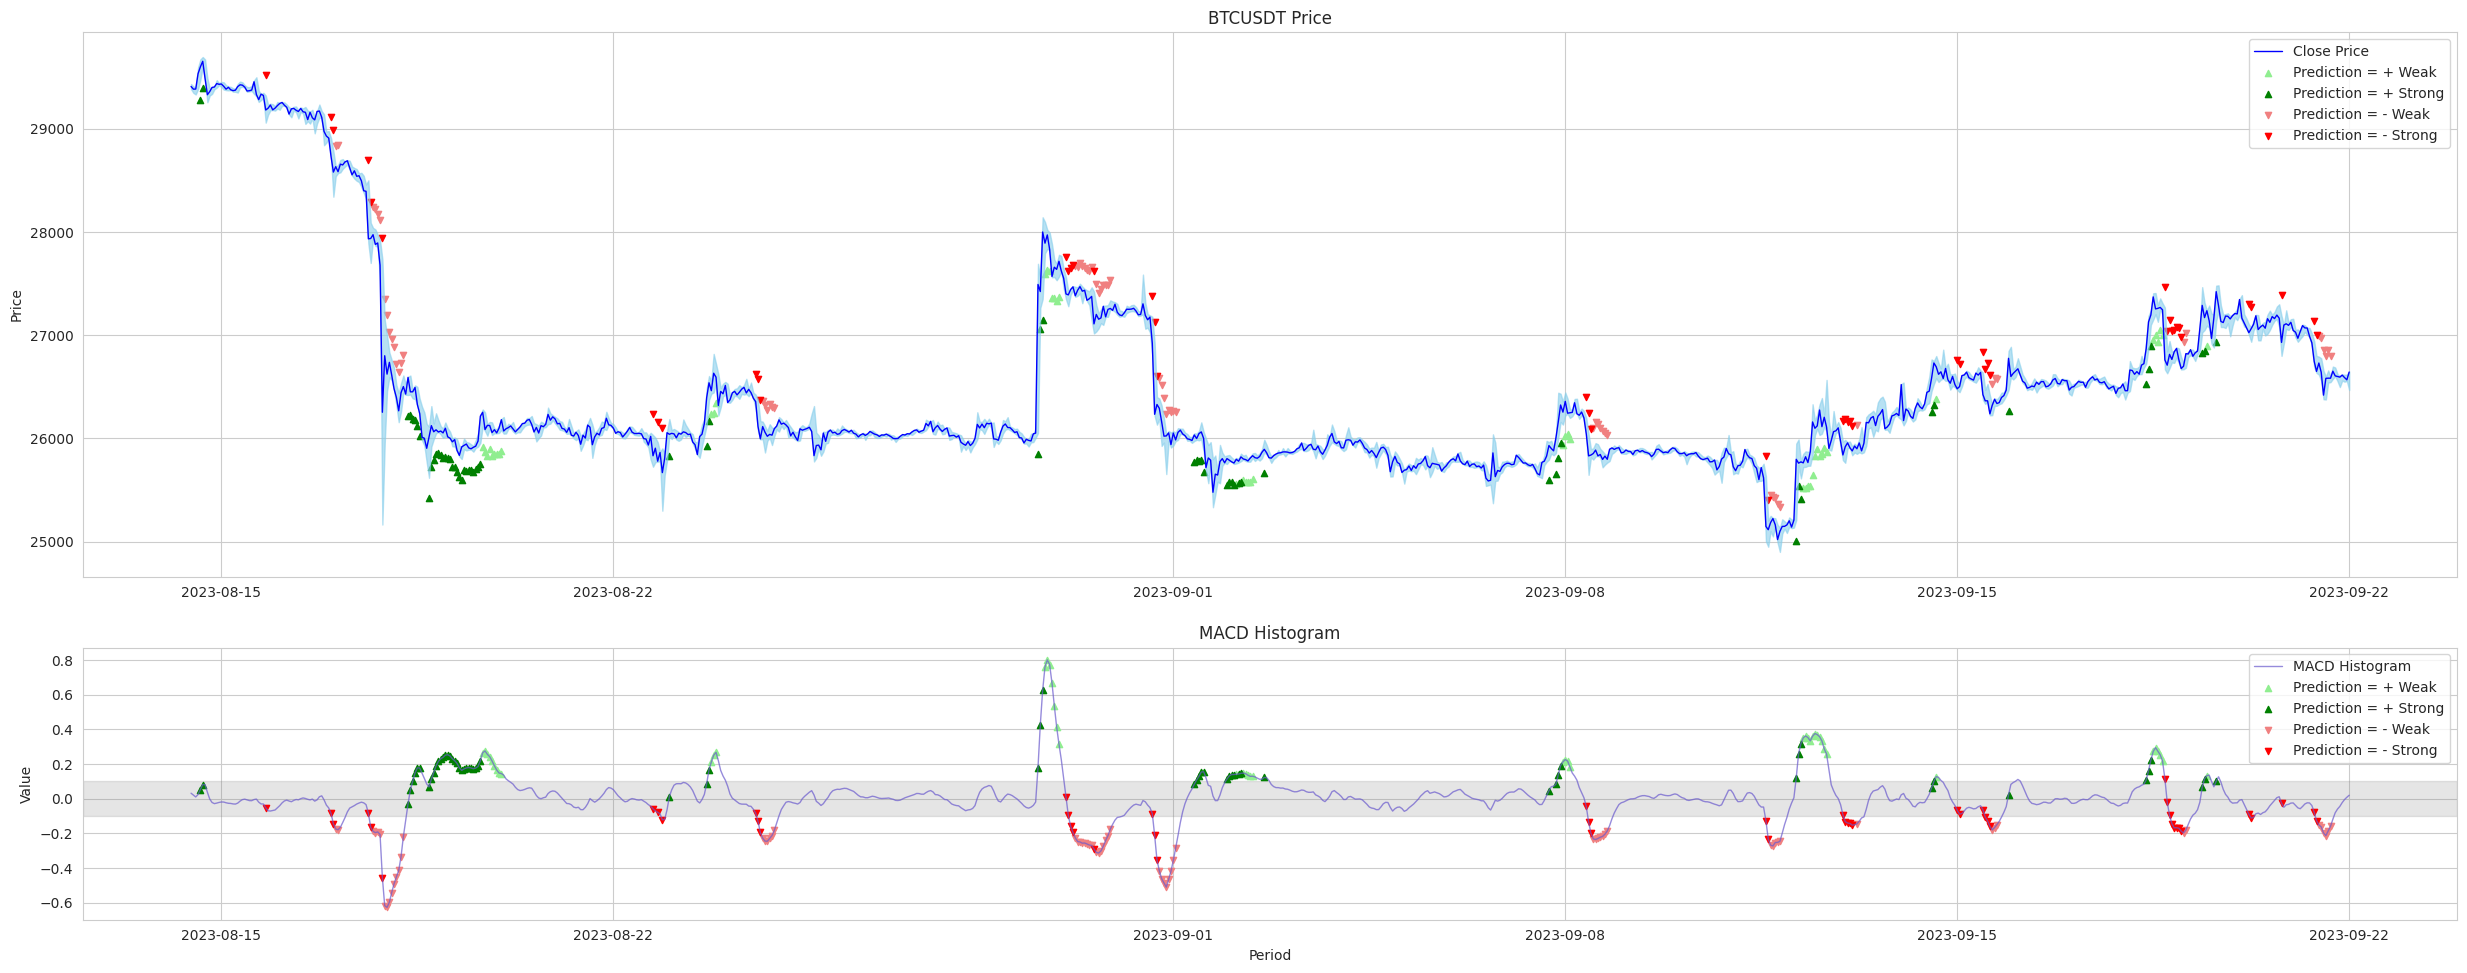

In [175]:
import talib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_live_prediction(df_live, model_name = 'tmp_model', model_path = './models/'):
    # Get prediction result
    y_live_pred = predict_live_data(df_live, model_name = model_name, model_path = model_path)

    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred
    # pred_result.dropna(inplace=True)

    # ohlc
    pred_result['ohlc'] = (pred_result['open'] + pred_result['high'] + pred_result['low'] + pred_result['close']) / 4

    # MACD
    pred_result['macd_hist'] = talib.MACD(pred_result['ohlc'], fastperiod=12, slowperiod=26, signalperiod=9)[2]
    pred_result['macd_hist'] = pred_result['macd_hist'] / pred_result['ohlc'] * 100 # scale

    pred_result.dropna(inplace=True)
    
    # print(pred_result.shape)

    # Plot
    # Set seaborn style
    sns.set_style("whitegrid")

    # Create subplots: one for price, one for MACD histogram
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10), gridspec_kw={'height_ratios': [2, 1]})
    fig.tight_layout(pad=3.0)

    # Plotting price data on the first subplot
    axes[0].plot(pred_result['close'], label='Close Price', color='blue', linewidth=1)

    axes[0].scatter(
            pred_result[pred_result['prediction'] == 1].index, 
            pred_result[pred_result['prediction'] == 1]['low'] - 200, 
            color='lightgreen', 
            marker='^', 
            label='Prediction = + Weak',
            s=20,
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == 2].index, 
            pred_result[pred_result['prediction'] == 2]['low'] - 200, 
            color='green', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == -1].index, 
            pred_result[pred_result['prediction'] == -1]['high'] + 200, 
            color='lightcoral',
            marker='v', 
            label='Prediction = - Weak',
            s=20,
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == -2].index, 
            pred_result[pred_result['prediction'] == -2]['high'] + 200, 
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )

    axes[0].set_title('BTCUSDT Price')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='upper right')

    # Filling in the area between high and low prices (optional)
    axes[0].fill_between(pred_result.index, pred_result['high'], pred_result['low'], color='skyblue', alpha=0.6)

    # draw gray area between +0.1 and -0.1
    axes[1].axhspan(-0.1, 0.1, alpha=0.2, color='gray')

    # Plotting MACD histogram on the second subplot
    # line plot
    axes[1].plot(pred_result.index, pred_result['macd_hist'], label='MACD Histogram', color='slateblue', alpha=0.7, linewidth=1)

    axes[1].scatter(
            pred_result[pred_result['prediction'] == 1].index, 
            pred_result[pred_result['prediction'] == 1]['macd_hist'], 
            color='lightgreen', 
            marker='^', 
            label='Prediction = + Weak',
            s=20,
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == 2].index, 
            pred_result[pred_result['prediction'] == 2]['macd_hist'], 
            color='green', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == -1].index, 
            pred_result[pred_result['prediction'] == -1]['macd_hist'], 
            color='lightcoral',
            marker='v', 
            label='Prediction = - Weak',
            s=20,
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == -2].index, 
            pred_result[pred_result['prediction'] == -2]['macd_hist'], 
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )

    axes[1].set_title('MACD Histogram')
    axes[1].set_ylabel('Value')
    axes[1].set_xlabel('Period')
    axes[1].legend(loc='upper right')

    # Display the plot
    plt.show()

    return pred_result

pred_result = plot_live_prediction(df_live, model_name = 'btc_macd_2hr_trend_unseen')


----

### Experiment 8: Predict Trend from EMAs

There are issues when using the MACD histogram for predictions; it provided false signals on 18 Aug and 2 Sep due to its sensitivity. 

For this experiment, we plan to employ a simpler trend indicator, utilizing various levels of fast and slow EMAs (Exponential Moving Averages).

However, a challenge with this type of indicator is that it tends to lag behind real-time events. To address this, we'll implement a machine learning model. The goal is to predict the trend in advance, providing an early signal beneficial for our trading system.

In [225]:
def get_target_next_ema_diff(df, target_shift = 2):
    
    target_threshold = 0.2
    # oclh
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    # diff between ema 10 and 20
    df['ema_10'] = talib.EMA(df['ohlc'], timeperiod=10)
    df['ema_20'] = talib.EMA(df['ohlc'], timeperiod=20)
    df['ema_diff'] = (df['ema_10'] - df['ema_20']) / df['ohlc'] * 100

    conditions = [
        (df['ema_diff'].isnull()),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] > df['ema_diff'].shift(1)),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] <= df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] >= df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] < df['ema_diff'].shift(1))
    ]
    values = [np.nan, 2, 1, -1, -2]
    df['target'] = np.select(conditions, values, default=0,)

    # shift target
    df['target'] = df['target'].shift(target_shift * -1)

    # drop columns
    df.drop(columns=['ohlc', 'ema_10', 'ema_20', 'ema_diff'], inplace=True)

    return df


df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=2)
df = get_features_v2(df)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    8815
 1.0    3757
-1.0    3720
-2.0    3284
 2.0    3264
Name: count, dtype: int64
Shape (22840, 157)


,target,open_pct_3,open_rsi_3,open_trix_3,open_roc_3,high_pct_3,high_rsi_3,high_trix_3,high_roc_3,low_pct_3,...,volume_pct_25,volume_rsi_25,volume_trix_25,volume_roc_25,price_atr_25,price_interact_25,pv_interact_25,price_adx_25,mfi_25,price_dx_25
count,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,...,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000,22840.000000
mean,-0.000131,0.000051,50.176682,-0.000709,0.005073,0.000044,48.182639,-0.000756,0.004367,0.000063,...,0.004027,49.936641,-0.000673,0.402708,371.505487,-0.440465,-0.000226,21.835691,50.260196,21.836012
std,1.214162,0.012869,23.982146,0.268630,1.286878,0.012378,25.871478,0.263065,1.237755,0.013623,...,0.094314,2.934557,0.114959,9.431374,255.666710,24.331336,0.004059,9.787188,10.179957,16.323666
min,-2.000000,-0.113669,0.164893,-2.289916,-11.366926,-0.104237,0.047130,-2.067749,-10.423686,-0.152855,...,-0.763040,27.157503,-0.415390,-76.304045,26.149550,-276.323229,-0.050204,4.967913,15.665619,0.002850
25%,-1.000000,-0.004743,31.590199,-0.095406,-0.474267,-0.004854,27.152788,-0.100736,-0.485417,-0.004781,...,-0.053898,47.893645,-0.067286,-5.389767,162.098271,-4.650594,-0.000798,14.636925,43.531186,8.602127
50%,0.000000,0.000030,50.437010,0.001385,0.003031,-0.000398,47.452748,-0.007261,-0.039828,0.000463,...,-0.002002,49.614256,0.001172,-0.200198,317.625432,-0.005533,-0.000009,19.669984,50.816061,18.633316
75%,1.000000,0.004780,68.782318,0.097494,0.478024,0.004526,68.497237,0.095566,0.452607,0.005258,...,0.053887,51.731371,0.066823,5.388686,536.724648,4.813916,0.000644,27.071079,56.588332,31.830897
max,2.000000,0.147444,99.751964,2.167046,14.744365,0.147800,99.924076,2.402430,14.780014,0.143330,...,3.386263,64.403163,0.429206,338.626256,1815.752131,248.133257,0.197670,70.290866,92.594971,93.441613


**Remove data in Live from training set**

In [226]:
# earliest date time in live data
earliest_datetime = df_live.index.min()
print(f"Remove traning data after {earliest_datetime}")

# Remove training data in df after 2023-08-10 17:00:00
df_train = df[df.index < earliest_datetime]

print(f"Original training data shape: {df.shape}")
print(f"Unseen training data shape: {df_train.shape}")

Remove traning data after 2023-08-11 10:00:00
Original training data shape: (22840, 157)
Unseen training data shape: (22555, 157)


**Train with unseen data**

In [227]:
model = train_voting_model(df_train, model_name = 'btc_ema_2hr_trend')

Confusion Matrix
[[ 101   30   34    0    0]
 [  29  180    7    0    0]
 [  27   16 1401   10   18]
 [   0    0   13  178   35]
 [   0    0   33   28  116]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.64      0.61      0.63       165
        -1.0       0.80      0.83      0.81       216
         0.0       0.94      0.95      0.95      1472
         1.0       0.82      0.79      0.81       226
         2.0       0.69      0.66      0.67       177

    accuracy                           0.88      2256
   macro avg       0.78      0.77      0.77      2256
weighted avg       0.87      0.88      0.87      2256

Voting soft F1-Score: 0.8748, Accuracy: 0.8759
Duration: 0.82 minutes
Save scaler to ./models/btc_ema_2hr_trend_scaler.joblib
Save model to ./models/btc_ema_2hr_trend_model.joblib


In [228]:
def evaluate_live_data_target_ema_diff(df_live, model_name = 'tmp_model', model_path = './models/'):
    # Get prediction result
    y_live_pred = predict_live_data(df_live, model_name = model_name, model_path = model_path)

    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # Get target
    pred_result = get_target_next_ema_diff(pred_result, target_shift=2)
    pred_result.dropna(inplace=True)

    y_test = pred_result['target']
    y_pred = pred_result['prediction']
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print(f"Model evaluation with live data F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    return None


model_eval = evaluate_live_data_target_ema_diff(df_live, model_name = 'btc_ema_2hr_trend')

Confusion Matrix
[[ 38  22   2   0   0]
 [  4  84   0   0   0]
 [ 71  47 467  32  26]
 [  0   0   0  63  12]
 [  0   0   2  12  42]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.34      0.61      0.43        62
        -1.0       0.55      0.95      0.70        88
         0.0       0.99      0.73      0.84       643
         1.0       0.59      0.84      0.69        75
         2.0       0.53      0.75      0.62        56

    accuracy                           0.75       924
   macro avg       0.60      0.78      0.66       924
weighted avg       0.84      0.75      0.77       924

Model evaluation with live data F1-Score: 0.7726, Accuracy: 0.7511


**Predict and plot with live data**

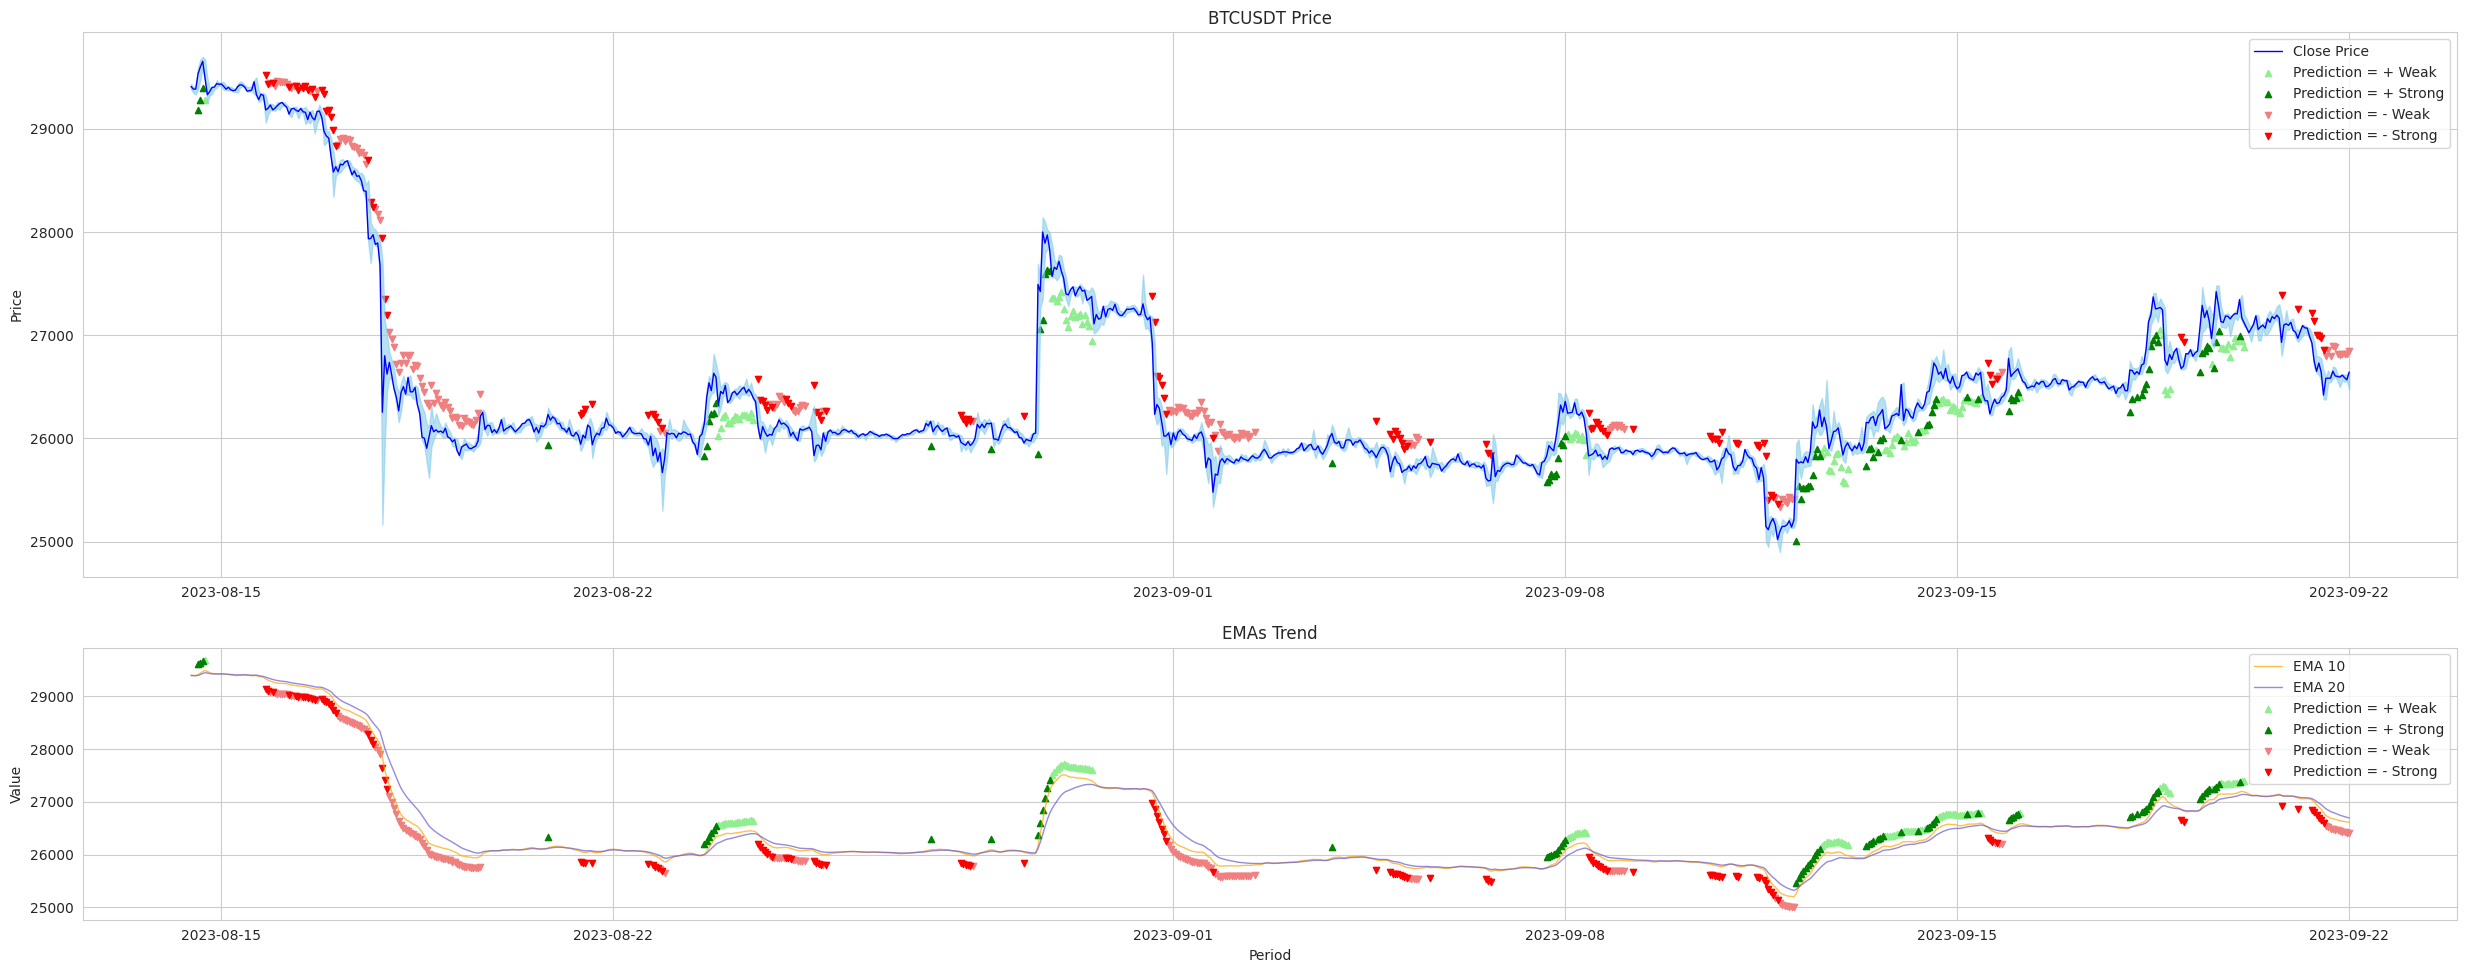

In [244]:
import talib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_live_prediction_ema(df_live, model_name = 'tmp_model', model_path = './models/'):
    # Get prediction result
    y_live_pred = predict_live_data(df_live, model_name = model_name, model_path = model_path)

    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # ohlc
    pred_result['ohlc'] = (pred_result['open'] + pred_result['high'] + pred_result['low'] + pred_result['close']) / 4

    # diff between ema 10 and 20
    pred_result['ema_10'] = talib.EMA(pred_result['ohlc'], timeperiod=10)
    pred_result['ema_20'] = talib.EMA(pred_result['ohlc'], timeperiod=20)

    pred_result.dropna(inplace=True)
    
    # print(pred_result.shape)

    # Plot
    # Set seaborn style
    sns.set_style("whitegrid")

    # Create subplots: one for price, one for MACD histogram
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10), gridspec_kw={'height_ratios': [2, 1]})
    fig.tight_layout(pad=3.0)

    # Plotting price data on the first subplot
    axes[0].plot(pred_result['close'], label='Close Price', color='blue', linewidth=1)

    axes[0].scatter(
            pred_result[pred_result['prediction'] == 1].index, 
            pred_result[pred_result['prediction'] == 1]['low'] - 200, 
            color='lightgreen', 
            marker='^', 
            label='Prediction = + Weak',
            s=20,
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == 2].index, 
            pred_result[pred_result['prediction'] == 2]['low'] - 200, 
            color='green', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == -1].index, 
            pred_result[pred_result['prediction'] == -1]['high'] + 200, 
            color='lightcoral',
            marker='v', 
            label='Prediction = - Weak',
            s=20,
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == -2].index, 
            pred_result[pred_result['prediction'] == -2]['high'] + 200, 
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )

    axes[0].set_title('BTCUSDT Price')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='upper right')

    # Filling in the area between high and low prices (optional)
    axes[0].fill_between(pred_result.index, pred_result['high'], pred_result['low'], color='skyblue', alpha=0.6)

    # line plot EMA 10 and 20
    axes[1].plot(pred_result.index, pred_result['ema_10'], label='EMA 10', color='orange', alpha=0.7, linewidth=1)
    axes[1].plot(pred_result.index, pred_result['ema_20'], label='EMA 20', color='slateblue', alpha=0.7, linewidth=1)

    axes[1].scatter(
            pred_result[pred_result['prediction'] == 1].index, 
            pred_result[pred_result['prediction'] == 1]['ema_10'] + 200, 
            color='lightgreen', 
            marker='^', 
            label='Prediction = + Weak',
            s=20,
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == 2].index, 
            pred_result[pred_result['prediction'] == 2]['ema_10'] + 200, 
            color='green', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == -1].index, 
            pred_result[pred_result['prediction'] == -1]['ema_10'] - 200, 
            color='lightcoral',
            marker='v', 
            label='Prediction = - Weak',
            s=20,
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == -2].index, 
            pred_result[pred_result['prediction'] == -2]['ema_10'] - 200, 
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )

    axes[1].set_title('EMAs Trend')
    axes[1].set_ylabel('Value')
    axes[1].set_xlabel('Period')
    axes[1].legend(loc='upper right')

    # Display the plot
    plt.show()

    return pred_result


pred_result = plot_live_prediction_ema(df_live, model_name = 'btc_ema_2hr_trend')

Utilizing levels of EMAs provided an early indication of the onset of a trend. 
- Notably, these signals demonstrated consistent trends, making them user-friendly as a guideline. 
- While some false signals emerged, they were significantly fewer compared to when we used the MACD.

To conclude this ML experiment: 
- the predictive capability of our model is confined to a short 1-2 hour horizon. 

For upcoming experiments, we aim to explore more potent models, like `Deep Learning`, to extend our predictive reach further into the future.